# Evaluate Trained RL Policy: Gazebo GUI + TensorBoard

This notebook evaluates a trained SAC policy in two complementary ways:

1. **Gym evaluation** with TensorBoard logging — multi-episode eval with scalar/histogram/image metrics
2. **Gazebo SITL** with GUI — launch Gazebo and watch the drone fly in 3D

**Sections:**

| # | Section | What it does |
|---|---------|-------------|
| 1 | Setup & Load Model | Load a trained `.zip` policy and inspect it |
| 2 | TensorBoard Launch | Start TensorBoard inline to view metrics live |
| 3 | Gym Evaluation + TB Logging | Run N episodes, log rewards/errors/trajectories to TensorBoard |
| 4 | Detailed Telemetry Plots | Matplotlib deep-dive on a single episode |
| 5 | Launch Gazebo GUI | Start Gazebo SITL with the RL policy node |
| 6 | Cleanup | Shut down everything |

**Requirements:**
```bash
pip install -e ".[train,sim]" 
pip install ipykernel ipywidgets matplotlib tensorboard
# For Gazebo: ROS 2 Jazzy, ros_gz_bridge, colcon workspace built
```

## 1. Setup & Load Model

In [1]:
import os
import signal
import subprocess
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from stable_baselines3 import SAC
from torch.utils.tensorboard import SummaryWriter

from training.envs.config import HoverEnvConfig
from training.scripts.train_hover import count_actor_params, make_env

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib widget
print("Imports OK.")

Imports OK.


In [2]:
# ── Configuration ──────────────────────────────────────────────────────
MODEL_PATH = "training/models/hover_quicktest.zip"  # <-- change to your trained model
N_EVAL_EPISODES = 10  # Number of gym evaluation episodes
SEED = 42

# Gazebo launch settings (used in Section 5)
GAZEBO_WORLD = "empty_flat"  # World SDF name (without .sdf)
HOVER_HEIGHT = 1.0  # Goal altitude in metres

# TensorBoard log directory
EVAL_LOG_DIR = Path("training/logs/eval") / datetime.now().strftime("%Y%m%d_%H%M%S")
EVAL_LOG_DIR.mkdir(parents=True, exist_ok=True)
print(f"TensorBoard logs: {EVAL_LOG_DIR}")

TensorBoard logs: training/logs/eval/20260208_235408


In [3]:
# ── Load model ─────────────────────────────────────────────────────────
model_path = Path(MODEL_PATH)
if not model_path.is_absolute():
    # Resolve relative to project root
    project_root = Path.cwd()
    while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
        project_root = project_root.parent
    model_path = project_root / model_path

if not model_path.exists() and not model_path.with_suffix(".zip").exists():
    raise FileNotFoundError(f"Model not found: {model_path}")

model = SAC.load(str(model_path))
print(f"Model loaded from: {model_path}")
print(f"Actor parameters:  {count_actor_params(model)} (RL008 limit: 19,076)")

# ── Create eval environment ────────────────────────────────────────────
env_config = HoverEnvConfig.default()
eval_env = make_env(env_config, seed=SEED, eval_mode=True)
print(f"Observation space: {eval_env.observation_space}")
print(f"Action space:      {eval_env.action_space}")
print(
    f"Episode length:    {env_config.max_episode_time}s at {env_config.control_freq}Hz "
    f"= {int(env_config.max_episode_time * env_config.control_freq)} steps"
)

Model loaded from: /home/ratan/projects/End-to-End-RL-agent-UAV-flight-controller/training/models/hover_quicktest.zip
Actor parameters:  19592 (RL008 limit: 19,076)
Observation space: Box(-1.0, 1.0, (15,), float32)
Action space:      Box(-1.0, 1.0, (4,), float32)
Episode length:    30.0s at 50Hz = 1500 steps


## 2. Launch TensorBoard

Run the cell below to start TensorBoard inline. If it does not render, open http://localhost:6006 in your browser.

In [4]:
%load_ext tensorboard
%tensorboard --logdir training/logs/eval --port 6006 --bind_all

## 3. Gym Evaluation + TensorBoard Logging

Run `N_EVAL_EPISODES` deterministic rollouts, logging to TensorBoard:

| Metric (Scalars) | Description |
|------------------|-------------|
| `eval/episode_reward` | Total reward per episode |
| `eval/episode_length` | Steps until termination / truncation |
| `eval/final_pos_error` | Euclidean distance from goal at episode end |
| `eval/mean_pos_error` | Average position error over the episode |
| `eval/max_tilt_deg` | Maximum roll/pitch angle reached |
| `eval/survived` | 1 if episode was truncated (full length), 0 if terminated early |

| Histograms | Description |
|------------|-------------|
| `eval/motor_speeds` | Distribution of motor commands |
| `eval/actions` | Distribution of raw policy outputs |

| Images | Description |
|--------|-------------|
| `eval/trajectory_3d` | Rendered 3D trajectory plot per episode |

AttributeError: 'Canvas' object has no attribute 'tostring_rgb'

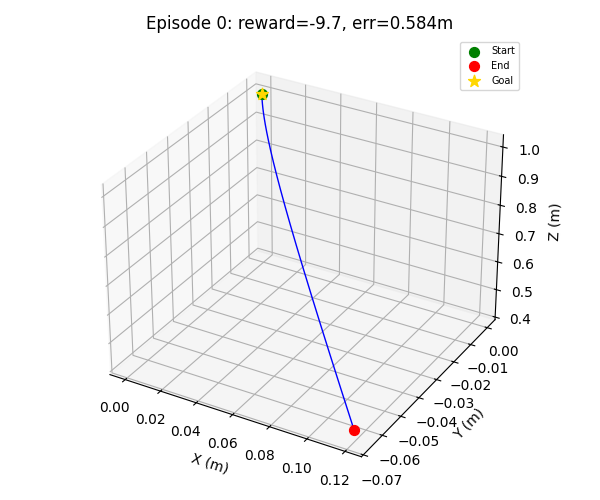

In [6]:
writer = SummaryWriter(log_dir=str(EVAL_LOG_DIR))

max_steps = int(env_config.max_episode_time * env_config.control_freq)
all_rewards = []
all_pos_errors = []
all_lengths = []

# Store every episode's trajectory for the summary plot
all_trajectories = []

for ep in range(N_EVAL_EPISODES):
    obs, info = eval_env.reset(seed=SEED + ep)
    goal = info["goal"]
    ep_reward = 0.0

    positions, velocities, eulers, motor_cmds, actions_log = [], [], [], [], []

    for _step in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        ep_reward += float(reward)

        positions.append(info["position"].copy())
        velocities.append(info["velocity"].copy())
        eulers.append(np.degrees(info["euler"]))
        motor_cmds.append(info["motor_speeds"].copy())
        actions_log.append(action.copy())

        if terminated or truncated:
            break

    positions = np.array(positions)
    velocities = np.array(velocities)
    eulers = np.array(eulers)
    motor_cmds = np.array(motor_cmds)
    actions_arr = np.array(actions_log)

    pos_errors = np.linalg.norm(goal - positions, axis=1)
    final_pos_error = float(pos_errors[-1])
    mean_pos_error = float(np.mean(pos_errors))
    max_tilt = float(np.max(np.abs(eulers[:, :2])))  # max of |roll|, |pitch|
    survived = 1.0 if truncated and not terminated else 0.0

    all_rewards.append(ep_reward)
    all_pos_errors.append(final_pos_error)
    all_lengths.append(len(positions))
    all_trajectories.append(positions)

    # ── Scalars ──
    writer.add_scalar("eval/episode_reward", ep_reward, ep)
    writer.add_scalar("eval/episode_length", len(positions), ep)
    writer.add_scalar("eval/final_pos_error", final_pos_error, ep)
    writer.add_scalar("eval/mean_pos_error", mean_pos_error, ep)
    writer.add_scalar("eval/max_tilt_deg", max_tilt, ep)
    writer.add_scalar("eval/survived", survived, ep)

    # ── Histograms ──
    writer.add_histogram("eval/motor_speeds", motor_cmds.flatten(), ep)
    writer.add_histogram("eval/actions", actions_arr.flatten(), ep)
    writer.add_histogram("eval/position_errors", pos_errors, ep)

    # ── 3D trajectory image ──
    fig_tb = plt.figure(figsize=(6, 5))
    ax_tb = fig_tb.add_subplot(111, projection="3d")
    ax_tb.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], "b-", linewidth=1)
    ax_tb.scatter(*positions[0], color="green", s=50, label="Start")
    ax_tb.scatter(*positions[-1], color="red", s=50, label="End")
    ax_tb.scatter(*goal, color="gold", s=80, marker="*", label="Goal")
    ax_tb.set_xlabel("X (m)")
    ax_tb.set_ylabel("Y (m)")
    ax_tb.set_zlabel("Z (m)")
    ax_tb.set_title(f"Episode {ep}: reward={ep_reward:.1f}, err={final_pos_error:.3f}m")
    ax_tb.legend(fontsize=7)
    fig_tb.tight_layout()

    # Render to numpy array for TensorBoard
    fig_tb.canvas.draw()
    img_array = np.frombuffer(fig_tb.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape((*fig_tb.canvas.get_width_height()[::-1], 3))
    writer.add_image("eval/trajectory_3d", img_array, ep, dataformats="HWC")
    plt.close(fig_tb)

    status = "SURVIVED" if survived else "CRASHED"
    print(
        f"  Episode {ep:2d}: reward={ep_reward:8.1f}  length={len(positions):4d}  "
        f"pos_err={final_pos_error:.4f}m  tilt={max_tilt:.1f}deg  [{status}]"
    )

# ── Summary scalars ──
writer.add_scalar("eval_summary/mean_reward", float(np.mean(all_rewards)), 0)
writer.add_scalar("eval_summary/std_reward", float(np.std(all_rewards)), 0)
writer.add_scalar("eval_summary/mean_pos_error", float(np.mean(all_pos_errors)), 0)
writer.add_scalar("eval_summary/mean_length", float(np.mean(all_lengths)), 0)
n_survived = sum(1 for ep_len in all_lengths if ep_len == max_steps)
writer.add_scalar("eval_summary/survival_rate", n_survived / N_EVAL_EPISODES, 0)

writer.flush()

print(f"\n{'=' * 60}")
print(f"  Evaluation Summary ({N_EVAL_EPISODES} episodes)")
print(f"{'=' * 60}")
print(f"  Reward:     {np.mean(all_rewards):8.1f} +/- {np.std(all_rewards):.1f}")
print(f"  Pos error:  {np.mean(all_pos_errors):8.4f} +/- {np.std(all_pos_errors):.4f} m")
print(f"  Ep length:  {np.mean(all_lengths):8.1f} +/- {np.std(all_lengths):.1f} steps")
print(f"  Survival:   {n_survived}/{N_EVAL_EPISODES}")
print(f"{'=' * 60}")
print(f"  TensorBoard: tensorboard --logdir {EVAL_LOG_DIR.parent}")

## 4. Detailed Telemetry Plots

Deep-dive into the **best episode** (highest reward) with 6-panel telemetry.

In [7]:
# Re-run the best episode for detailed data
best_ep_idx = int(np.argmax(all_rewards))
print(f"Best episode: {best_ep_idx} (reward={all_rewards[best_ep_idx]:.1f})")

obs, info = eval_env.reset(seed=SEED + best_ep_idx)
goal = info["goal"]
positions, velocities, eulers, motor_cmds, rewards_ep = [], [], [], [], []

for _step in range(max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    positions.append(info["position"].copy())
    velocities.append(info["velocity"].copy())
    eulers.append(np.degrees(info["euler"]))
    motor_cmds.append(info["motor_speeds"].copy())
    rewards_ep.append(reward)
    if terminated or truncated:
        break

positions = np.array(positions)
velocities = np.array(velocities)
eulers = np.array(eulers)
motor_cmds = np.array(motor_cmds)
t = np.arange(len(positions)) / env_config.control_freq

print(f"Episode: {len(positions)} steps ({t[-1]:.1f}s)")
print(f"Total reward: {sum(rewards_ep):.1f}")
print(f"Final pos error: {np.linalg.norm(goal - positions[-1]):.4f} m")

Best episode: 0 (reward=-9.7)
Episode: 26 steps (0.5s)
Total reward: -9.7
Final pos error: 0.5843 m


AttributeError: 'Canvas' object has no attribute 'tostring_rgb'

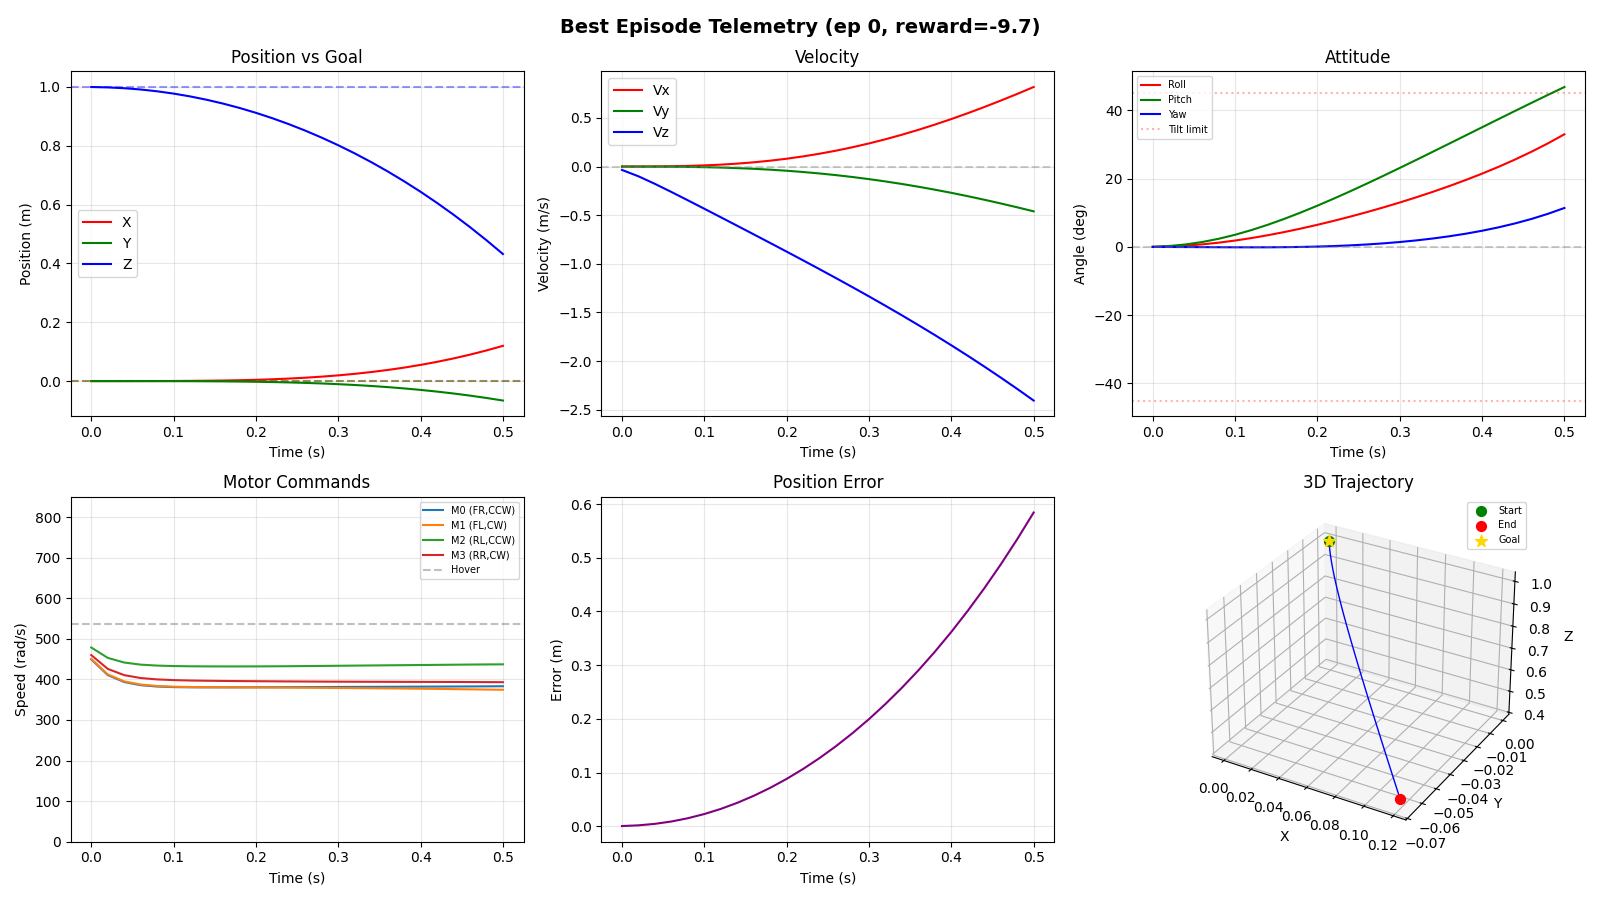

In [8]:
fig2, axes = plt.subplots(2, 3, figsize=(16, 9))
fig2.suptitle(
    f"Best Episode Telemetry (ep {best_ep_idx}, reward={all_rewards[best_ep_idx]:.1f})",
    fontsize=14,
    fontweight="bold",
)

# Position XYZ
ax = axes[0, 0]
for i, (label, color) in enumerate(zip(["X", "Y", "Z"], ["r", "g", "b"], strict=True)):
    ax.plot(t, positions[:, i], color=color, label=label)
    ax.axhline(goal[i], color=color, linestyle="--", alpha=0.4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (m)")
ax.set_title("Position vs Goal")
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity XYZ
ax = axes[0, 1]
for i, (label, color) in enumerate(zip(["Vx", "Vy", "Vz"], ["r", "g", "b"], strict=True)):
    ax.plot(t, velocities[:, i], color=color, label=label)
ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (m/s)")
ax.set_title("Velocity")
ax.legend()
ax.grid(True, alpha=0.3)

# Euler angles
ax = axes[0, 2]
for i, (label, color) in enumerate(zip(["Roll", "Pitch", "Yaw"], ["r", "g", "b"], strict=True)):
    ax.plot(t, eulers[:, i], color=color, label=label)
ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
ax.axhline(45, color="red", linestyle=":", alpha=0.3, label="Tilt limit")
ax.axhline(-45, color="red", linestyle=":", alpha=0.3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (deg)")
ax.set_title("Attitude")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Motor speeds
ax = axes[1, 0]
motor_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
motor_names = ["M0 (FR,CCW)", "M1 (FL,CW)", "M2 (RL,CCW)", "M3 (RR,CW)"]
for i in range(4):
    ax.plot(t, motor_cmds[:, i], color=motor_colors[i], label=motor_names[i])
ax.axhline(535.6, color="gray", linestyle="--", alpha=0.5, label="Hover")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Speed (rad/s)")
ax.set_title("Motor Commands")
ax.legend(fontsize=7)
ax.set_ylim(0, 850)
ax.grid(True, alpha=0.3)

# Position error over time
ax = axes[1, 1]
pos_err = np.linalg.norm(goal - positions, axis=1)
ax.plot(t, pos_err, "purple", linewidth=1.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Error (m)")
ax.set_title("Position Error")
ax.grid(True, alpha=0.3)

# 3D trajectory
ax = axes[1, 2]
ax.remove()
ax = fig2.add_subplot(2, 3, 6, projection="3d")
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], "b-", linewidth=1)
ax.scatter(*positions[0], color="green", s=50, label="Start")
ax.scatter(*positions[-1], color="red", s=50, label="End")
ax.scatter(*goal, color="gold", s=80, marker="*", label="Goal")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Trajectory")
ax.legend(fontsize=7)

plt.tight_layout()

# Also log the telemetry figure to TensorBoard
fig2.canvas.draw()
img_arr = np.frombuffer(fig2.canvas.tostring_rgb(), dtype=np.uint8)
img_arr = img_arr.reshape((*fig2.canvas.get_width_height()[::-1], 3))
writer.add_image("eval/best_episode_telemetry", img_arr, 0, dataformats="HWC")
writer.flush()

plt.show()
print("Telemetry figure logged to TensorBoard.")

## 5. Launch Gazebo GUI

This section launches the full **Gazebo SITL stack** with the trained RL policy node.
You will see the drone fly in the Gazebo 3D window.

**Prerequisites:**
- ROS 2 Jazzy installed at `/opt/ros/jazzy`
- Colcon workspace built (`simulation/ros2_ws/install/` exists)
- For GUI on WSL2: WSLg or an X server running

Press **Stop** (interrupt kernel) or run the cleanup cell to shut down Gazebo.

In [9]:
# ── Resolve paths ──────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists() and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

WS_DIR = PROJECT_ROOT / "simulation" / "ros2_ws"
ROS_SETUP = Path("/opt/ros/jazzy/setup.bash")

# ── Build workspace if needed ──────────────────────────────────────────
if (WS_DIR / "install").exists():
    print("[OK] Colcon workspace already built.")
else:
    print("[BUILD] Building colcon workspace...")
    build_cmd = f"source {ROS_SETUP} && cd {WS_DIR} && colcon build --symlink-install"
    result = subprocess.run(["bash", "-c", build_cmd], capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Build FAILED:\n{result.stderr}")
    else:
        print("[OK] Workspace built.")

# ── Resolve model path to absolute ─────────────────────────────────────
abs_model_path = model_path.resolve()
print(f"Model:  {abs_model_path}")
print(f"World:  {GAZEBO_WORLD}")
print(f"Hover:  {HOVER_HEIGHT}m")

[OK] Colcon workspace already built.
Model:  /home/ratan/projects/End-to-End-RL-agent-UAV-flight-controller/training/models/hover_quicktest.zip
World:  empty_flat
Hover:  1.0m


In [11]:
# ── Launch Gazebo SITL with RL policy ──────────────────────────────────
launch_cmd = (
    f"source {ROS_SETUP} && "
    f"source {WS_DIR}/install/local_setup.bash && "
    f"ros2 launch uav_sim sitl_rl.launch.py "
    f"model_path:={abs_model_path} "
    f"world:={GAZEBO_WORLD} "
    f"hover_height:={HOVER_HEIGHT}"
)

print("Starting Gazebo SITL with RL policy...")
print("(Interrupt kernel or run cleanup cell to stop)\n")

gazebo_process = subprocess.Popen(
    ["bash", "-c", launch_cmd],
    cwd=str(PROJECT_ROOT),
    preexec_fn=os.setsid,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
)

print(f"Gazebo PID: {gazebo_process.pid}")
print("Gazebo GUI should open shortly...")
print("Streaming output (first 50 lines):")
print("-" * 60)

try:
    for i, line in enumerate(gazebo_process.stdout):
        print(line, end="")
        if i >= 50:
            print("\n... (output truncated, Gazebo running in background)")
            break
except KeyboardInterrupt:
    print("\n[Interrupted] Gazebo still running. Use cleanup cell to stop.")

Starting Gazebo SITL with RL policy...
(Interrupt kernel or run cleanup cell to stop)

Gazebo PID: 16122
Gazebo GUI should open shortly...
Streaming output (first 50 lines):
------------------------------------------------------------
[INFO] [launch]: All log files can be found below /home/ratan/.ros/log/2026-02-08-23-55-22-159381-lali-16122
[INFO] [launch]: Default logging verbosity is set to INFO
[INFO] [gz-1]: process started with pid [16135]
[INFO] [parameter_bridge-2]: process started with pid [16136]
[INFO] [rl_policy_node-3]: process started with pid [16137]
[gz-1] QObject::moveToThread: Current thread (0x6002702eb180) is not the object's thread (0x6002702e6a40).
[gz-1] Cannot move to target thread (0x6002702eb180)
[gz-1] 
[gz-1] qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/ratan/projects/End-to-End-RL-agent-UAV-flight-controller/.venv/lib/python3.12/site-packages/cv2/qt/plugins" even though it was found.
[gz-1] This application failed to start because no

## 6. Cleanup

Run this cell to shut down Gazebo and close TensorBoard writer.

In [12]:
# ── Shut down Gazebo ───────────────────────────────────────────────────
if "gazebo_process" in dir() and gazebo_process.poll() is None:
    print("Shutting down Gazebo...")
    os.killpg(os.getpgid(gazebo_process.pid), signal.SIGINT)
    try:
        gazebo_process.wait(timeout=10)
        print("[OK] Gazebo stopped.")
    except subprocess.TimeoutExpired:
        os.killpg(os.getpgid(gazebo_process.pid), signal.SIGKILL)
        print("[OK] Gazebo force-killed.")
else:
    print("Gazebo not running.")

# ── Close TensorBoard writer ────────────────────────────────────────────
if "writer" in dir():
    writer.close()
    print("[OK] TensorBoard writer closed.")

# ── Close eval env ─────────────────────────────────────────────────────
if "eval_env" in dir():
    eval_env.close()
    print("[OK] Eval environment closed.")

print("\nDone! TensorBoard logs saved to:", EVAL_LOG_DIR)

Shutting down Gazebo...
[OK] Gazebo stopped.
[OK] TensorBoard writer closed.
[OK] Eval environment closed.

Done! TensorBoard logs saved to: training/logs/eval/20260208_235408
